In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
import time
from scipy.special import softmax
from tensorflow import keras
from tensorflow.keras import backend
# np.random.seed(0)

In [0]:
class Step:
    def __init__(self, state, action, reward, nextState, done):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = nextState
        self.done = done
        
    def __str__(self):
        return "{}, {}, {}, {}, {}".format(self.state, self.action, self.reward, self.next_state, self.done)
    
class ReplayMemory:
    def __init__(self, max_buffer_size):
        self.max_buffer_size = max_buffer_size
        self.buffer = np.array([Step(np.array([0, 1]), 1, 2, np.array([0, 1]), False) for _ in range(self.max_buffer_size)])
        self.buffer_size = 0
    
    def add(self, new_data):
#         print("Add in memory = ", len(new_data))
        assert self.buffer_size <= self.max_buffer_size
        assert len(new_data) <= self.max_buffer_size
        if self.buffer_size + len(new_data) > self.max_buffer_size:
            start_ind = len(new_data) - (self.max_buffer_size - self.buffer_size)
            new_buffer_size = self.buffer_size - start_ind
            self.buffer[: new_buffer_size] = self.buffer[start_ind : self.buffer_size]
            self.buffer_size = new_buffer_size
         
        self.buffer[self.buffer_size : self.buffer_size + len(new_data)] = new_data
        self.buffer_size = self.buffer_size + len(new_data)
        
    def sample(self, batch_size):
        indices = np.random.randint(0, self.buffer_size, size = batch_size)
        samples = self.buffer[indices, ]
        
        states = np.array([sample.state for sample in samples])
        actions = np.array([[sample.action] for sample in samples])
        rewards = np.array([[sample.reward] for sample in samples])
        nextStates = np.array([sample.next_state for sample in samples])
        dones = np.array([[sample.done] for sample in samples])
        
        return states, actions, rewards, nextStates, dones
        

class DQN:
    def __init__(self, max_buffer_size):
        self.memory = ReplayMemory(max_buffer_size)
        
    def initPredictionNetwork(self, inputSize, outputSize):
        inputs = tf.keras.Input(shape = (inputSize, ))
        f1 = tf.keras.layers.Dense(16*2, activation = 'relu')(inputs)
        f1 = tf.keras.layers.Dense(16*2, activation = 'relu')(f1)
        outputs = tf.keras.layers.Dense(outputSize, activation = 'linear')(f1)
        self.prediction_model = tf.keras.Model(inputs = inputs, outputs = outputs, name = "prediction_model")
    
    def initTargetNetwork(self, inputSize, outputSize):
        inputs = tf.keras.Input(shape = (inputSize, ))
        f1 = tf.keras.layers.Dense(16*2, activation = 'relu')(inputs)
        f1 = tf.keras.layers.Dense(16*2, activation = 'relu')(f1)
        outputs = tf.keras.layers.Dense(outputSize, activation = 'linear')(f1)
        self.target_model = tf.keras.Model(inputs = inputs, outputs = outputs, name = "target_model")
#         self.target_model = tf.keras.models.clone_model(self.prediction_model)
#         self.updateTargetNetwork()
    
    def updateTargetNetwork(self):
        self.target_model.set_weights(self.prediction_model.get_weights())

In [0]:
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(4,)


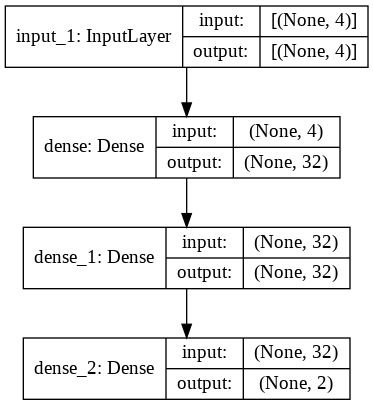

In [0]:
agent = DQN(10000)
agent.initPredictionNetwork(inputSize = 4, outputSize = 2)
agent.initTargetNetwork(inputSize = 4, outputSize = 2)
env.seed(0)
keras.utils.plot_model(agent.prediction_model, 'prediction_model.png', show_shapes=True)

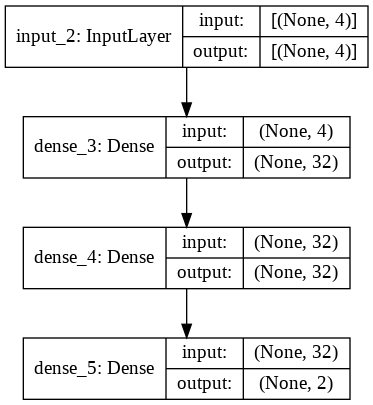

In [0]:
keras.utils.plot_model(agent.target_model, 'target_model.png', show_shapes=True)

In [0]:
def lossFunc(data, q_pred):
    actions, y = data[:, 0], data[:, 1]
    actions = tf.cast(actions, tf.int32)
    oneHotIndices = tf.one_hot(actions, depth = 2, on_value = 1.0, off_value = 0.0, dtype = tf.float32)
    pred_indices = tf.reduce_sum(tf.multiply(oneHotIndices, q_pred), axis = 1)
    loss = tf.square(tf.subtract(tf.stop_gradient(y), pred_indices))
    return tf.reduce_mean(loss)

optimizer = keras.optimizers.Adam(learning_rate = 0.001)
agent.prediction_model.compile(loss = lossFunc, optimizer = optimizer)
agent.target_model.compile(loss = lossFunc, optimizer = optimizer)


In [0]:
# %matplotlib notebook

agent.rewardRecord = []
agent.averageReward = []
agent.eps = 1.0
agent.epsDecay = 0.995
agent.prediction_model.optimizer.lr = 0.001
agent.alphaDecay  = .9995
agent.numEpisodes = 0
agent.train_history = {'loss': []}

def applyGD(agent):
    states, actions, rewards, nextStates, dones = agent.memory.sample(10 * agent.batch_size)
    q_target = agent.target_model.predict(nextStates)
    q_predict = agent.prediction_model.predict(nextStates)
    #Double Q Learning
    max_actions = np.argmax(q_predict, axis = 1)
    one_hot_actions = np.zeros((len(max_actions), 2))
    one_hot_actions[np.arange(len(max_actions)), max_actions] = 1.0
    q_target_max_actions = np.sum(np.multiply(one_hot_actions, q_target), axis = 1)
    
    target = rewards.flatten() + q_target_max_actions
    target[dones.flatten()] = rewards.flatten()[dones.flatten()]
    target = target.reshape((-1, 1))
    history = agent.prediction_model.fit(states, y = np.append(actions, target, axis= 1), epochs = 1, 
                               verbose = 0, batch_size= agent.batch_size)
    agent.train_history['loss'] += (history.history['loss'])


def playEpisode(agent):
    currData = []
    state = env.reset()
    for t in range(200):
        if np.random.random() < 1 - agent.eps: 
            action = np.argmax(agent.prediction_model.predict(np.array([state[0], state[1], state[2], state[3]]).reshape(1, 4)))
        else: action = np.random.randint(0, 2)

        nextState, reward, done, info = env.step(action)
        
        if done:
            if t < 199: 
                agent.memory.add([Step(state, action, reward, nextState, True)])
            agent.memory.add([Step(state, action, reward, nextState, False)])
            agent.numEpisodes += 1
            agent.rewardRecord.append(t)
            agent.eps = max(0.01, agent.eps * agent.epsDecay)

            break
          
        agent.memory.add([Step(state, action, reward, nextState, False)])
        state = nextState
    

agent.batch_size = 32
numEpisodes = 10000

print("episode : reward")
for i_eps in (range(numEpisodes)):
    agent.prediction_model.optimizer.lr = agent.alphaDecay * agent.prediction_model.optimizer.lr
    playEpisode(agent)
    if(i_eps % 40 == 0):
        print("{} : {}".format(i_eps, np.mean(agent.rewardRecord[-100:])))
    if agent.memory.buffer_size > agent.batch_size * 10:
        applyGD(agent)
        agent.updateTargetNetwork()


0 : 14.0
40 : 19.975609756097562
80 : 17.641975308641975
120 : 23.67
160 : 40.32
200 : 58.48
240 : 67.87
280 : 76.55
320 : 101.08
360 : 138.85
400 : 122.49
440 : 109.48
480 : 123.33
520 : 172.31
560 : 197.23
600 : 199.0
640 : 181.43
680 : 157.94
720 : 108.72
760 : 75.73
800 : 63.42
840 : 45.52
880 : 98.5
920 : 81.96
960 : 60.2
1000 : 85.62
1040 : 156.43
1080 : 199.0
1120 : 199.0
1160 : 199.0
1200 : 199.0
1240 : 199.0
1280 : 199.0
1320 : 199.0
1360 : 199.0
1400 : 170.14
1440 : 112.53
1480 : 41.88
1520 : 76.06
1560 : 134.46
1600 : 175.18
1640 : 181.17
1680 : 189.62
1720 : 196.59
1760 : 186.14
1800 : 166.83
1840 : 114.14
1880 : 77.54
1920 : 91.68
1960 : 137.97
2000 : 116.02
2040 : 70.06
2080 : 106.17
2120 : 177.51
2160 : 199.0
2200 : 199.0
2240 : 199.0
2280 : 199.0
2320 : 199.0
2360 : 199.0
2400 : 199.0
2440 : 199.0
2480 : 199.0
2520 : 199.0
2560 : 199.0
2600 : 199.0
2640 : 199.0
2680 : 199.0
2720 : 199.0
2760 : 199.0
2800 : 199.0
2840 : 199.0
2880 : 199.0
2920 : 199.0
2960 : 199.0
3000 :

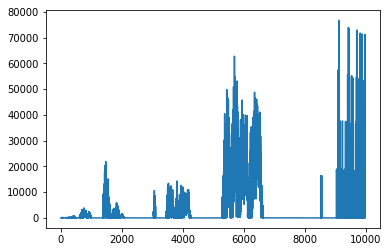

In [0]:
plt.plot(agent.train_history['loss'])
plt.show()

In [0]:
agent.train_history['loss'][-10:]

[17733.452824401855,
 38.62543277740478,
 35.610250854492186,
 39.55772094726562,
 39.21676521301269,
 71260.89346694946,
 17778.897771835327,
 39.35868320465088,
 53085.16419487,
 17659.152532196043]

In [0]:
# states, actions, rewards, nextStates, dones = agent.memory.sample(batch_size = 32)
# agent.prediction_model.predict(states)

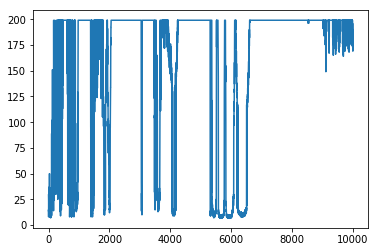

In [0]:
plt.plot(agent.rewardRecord)
plt.show()

### Plot the mean of last 100 episode at each point

In [0]:
meanReward = []
for i in range(len(agent.rewardRecord) -100):
    meanReward.append(np.mean(agent.rewardRecord[i: i + 100]))

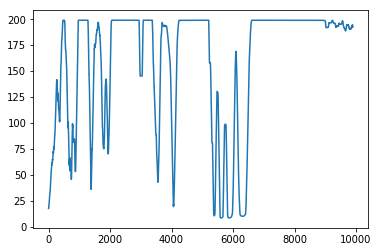

In [0]:
plt.plot(meanReward)